# "Monte Carlo Estimation of the State-value Function in Reinforcement Learning"

> Find state values under a given policy
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/MCEstimationOfStateValues.png
- categories: [Reinforcement_Learning,MC,  OpenAI,Gym,]
- show_tags: true

In [ ]:
# hide
# inspired by MC Prediction Solution_ANNO.ipynb

In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC/'

Mounted at /content/gdrive


In [2]:
# hide
%cd "{base_dir}"

/content/gdrive/My Drive/Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC


In [3]:
# hide
!pwd

/content/gdrive/My Drive/Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC


## 1. Introduction

In a *Markov Decision Process* (Figure 1) the *agent* and *environment* interacts continuously.

![Figure 1  Agent/Environment interaction in a MDP](../images/mc-prediction_agent-environment_fig1.png "Figure 1  Agent/Environment interaction in a MDP")

More details are available in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf).

The dynamics of the MDP is given by
$$ 
\begin{aligned}
p(s',r|s,a) &= Pr\{ S_{t+1}=s',R_{t+1}=r | S_t=s,A_t=a \} \\
\end{aligned}
$$

The *policy* of an agent is a mapping from the current state of the environment to an *action* that the agent needs to take in this state. Formally, a policy is given by
$$ 
\begin{aligned}
\pi(a|s) &= Pr\{A_t=a|S_t=s\}
\end{aligned}
$$

The discounted *return* is given by
$$ 
\begin{aligned}
G_t &= R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T \\
    &= \sum_{k=0}^\infty \gamma ^k R_{t+1+k}
\end{aligned}
$$
where $\gamma$ is the discount factor and $R$ is the *reward*.

Most reinforcement learning algorithms involve the estimation of value functions - in our present case, the *state-value function*. The state-value function maps each state to a measure of "how good it is to be in that state" in terms of expected rewards. Formally, the state-value function, under policy $\pi$ is given by
$$ 
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t|S_t=s]
\end{aligned}
$$

The Monte Carlo algorithm discussed in this post will numerically estimate $v_\pi(s)$.

## 2. Environment

The environment is the game of *Blackjack*. The player tries to get cards whose sum is as great as possible without exceeding 21. Face cards count as 10. An ace can be taken either as a 1 or an 11. Two cards are dealth to both dealer and player. One of the dealer's cards is face up (other is face down). The player can request additional cards, one by one (called *hits*) until the player stops (called *sticks*) or goes above 21 (goes *bust* and loses). When the players sticks it becomes the dealer's turn which uses a fixed strategy: sticks when the sum is 17 or greater and hits otherwise. If the dealer goes bust the player wins, otherwise the winner is determined by whose sum is closer to 21.

We formulate this game as an episodic finite MDP. Each game is an episode. 

* States are based on the player's
  * current sum (12-21)
    * player will automatically keep on getting cards until the sum is at least 12 (this is a rule and the player does not have a choice in this matter)
  * dealer's face up card (ace-10)
  * whether player holds usable ace (True or False)

This gives a total of 200 states: $10 × 10 \times 2 = 200$

* Rewards:
  * +1 for winning
  * -1 for losing
  * 0 for drawing

* Reward for stick:
  * +1 if sum > sum of dealer
  * 0 if sum = sum of dealer
  * -1 if sum < sum of dealer

* Reward for hit:
  * -1 if sum > 21
  * 0 otherwise

The environment is implemented using the OpenAI Gym library.

## 3. Agent

The *agent* is the player. After observing the state of the *environment*, the agent can take one of two possible actions:

* stick (0) [stop receiving cards]
* hit (1) [have another card]

The agent's policy will be deterministic - will always stick of the sum is 20 or 21, and hit otherwise. We call this *policy1* in the code.

## 4. Monte Carlo Estimation of the State-value Function, $v_\pi(s)$

We will now proceed to estimate the state-value function for the given policy $\pi$. We can take $\gamma=1$ as the sum will remain finite:

$$ \large
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t | S_t=s] \\
         &= \mathbb{E}_\pi[R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T | S_t=s] \\
         &= \mathbb{E}_\pi[R_{t+1} + R_{t+2} + R_{t+3} + ... + R_T | S_t=s]
\end{aligned}
$$

In numeric terms this means that, given a state, we take the sum of all rewards from that state onwards (following policy $\pi$) until the game ends, and take the average of all such sequences.


## 5. Implementation

We consider two versions of the MC Prediction algorithm: A forward version, and a backward version.

```
-----------------------------------------------------
First-visit MC Prediction (forward), for estimating V
-----------------------------------------------------
Input: a policy pi to be evaluated, positive integer n_episodes
Output: state-value function V
Initialize:
    V(s)       <- arbitrarily, for all s
    G_sum(s)   <- 0.0, for all s; running sum
    G_cnt(s)   <- 0, for all s; running count 

Repeat forever:
    Choose S0 s.t. all states have probability > 0
    Generate an episode starting from S0 following pi
    For each state s in the episode:
        G          <- return following the first occurrence of s
        G_sum(s)   <- G_sum(s) + G        #Add G to running sum
        G_count(s) <- G_count(s) + 1      #Increment running count
        V(s)       <- G_sum(s)/G_count(s) #Update running state value

```

Figure 1 shows the forward version:

![Figure 1  First-visit MC Prediction (forward), for estimating V](../images/MCPredictionForward_fig1.png "Figure 1  First-visit MC Prediction (forward), for estimating V")

Figure 2 shows the backward version:

![Figure 2  First-visit MC Prediction (backard), for estimating V](../images/MCPredictionBackward_fig2.png "Figure 2  First-visit MC Prediction (backward), for estimating V")

Next, we present the code that implements the algorithm.

In [4]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import pprint as pp
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
# hide
from lib import plotting as myplot
from lib.envs.blackjack import BlackjackEnv

In [6]:
# hide
# env = gym.make('Blackjack-v0')#.has differences cp to the one used here
#- env = gym.make('Blackjack-v1')#.does not exist

In [7]:
env = BlackjackEnv()

### 5.1 Policy

The following function captures the policy used by the agent:

In [8]:
def policy1(observation):
    player_sum, dealer_showing, usable_ace = observation
    if player_sum >=20:
      return 0 #stick
    else:
      return 1 #hit

### 5.2 Generate episodes

The following function sets the environment to a random initial state. It then enters a loop where each iteration applies the policy to the environment's state to obtain the next action to be taken by the agent. That action is then applied to the environment to get the next state, and so on until the episode ends.

In [9]:
def generate_episode(env, policy):
  episode = []
  state = env.reset() #to a random state
  while True:
      action = policy(state)
      next_state, reward, done, _ = env.step(action) # St+1, Rt+1 OR s',r
      episode.append((state, action, reward)) # St, At, Rt+1 OR s,a,r
      if done:
          break
      state = next_state
  return episode

### 5.3 Main loop

In this section we implement the main loop of the algorithm. It iterates for ``n_episodes``. It also takes a list of ``monitored_states`` for which it will record the evolution of state values. This is handy for showing how state values converge during the process.

#### 5.3.1 First-Visit Forward Algorithm

In [78]:
def first_visit_forward_algorithm(episode, G_sum, G_cnt, V, discount_factor, diag):
  #Find all visited states in this episode
  episode_states = set([tuple(sar[0]) for sar in episode]); print(f"-set of episode_states: {episode_states}") if diag else None #put state in tuple and use as key
  for state in episode_states: #don't use St, they come from set, time seq not relevant
      #--find the first visit to the state in the episode
      # first_visit_ix = next(i for i,sar in enumerate(episode) if sar[0]==state)
      visit_ixs = [i for i,sar in enumerate(episode) if sar[0]==state]; print(f'---state {state} visit_ixs: {visit_ixs}') if diag else None
      first_visit_ix = visit_ixs[0]; print(f"first_visit_ix: {first_visit_ix}") if diag else None
      #--sum up all rewards since the first visit
      print(f"episode[first_visit_ix:]: {episode[first_visit_ix:]}") if diag else None
      # print('episode[first_visit_ix + 1:]:', episode[first_visit_ix + 1:]) #NO - each r is the next reward Rt+1=r
      print(f"rewards: {[sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_ix:])]}") if diag else None
      G = sum([sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_ix:])]); print(f"G: {G}") if diag else None
      #--average return for this state over all sampled episodes
      #--instead of appending, keep a running sum and count
      G_sum[state] += G; G_cnt[state] += 1.0
      V[state] = G_sum[state]/G_cnt[state]

In [100]:
# hide
# debug
diag = True
discount_factor = 1.0
G_sum = defaultdict(float)
G_count = defaultdict(float)
V = defaultdict(float) #final value function
episode = [((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((12, 10, True), 1, -1)]; print('episode:', episode)
episode_states = set([tuple(sar[0]) for sar in episode]); print(f"-episode_states: {episode_states}") if diag else None
for state in episode_states:
    #--find the first visit to the state in the episode
    # first_visit_ix = next(i for i,sar in enumerate(episode) if sar[0]==state)
    visit_ixs = [i for i,sar in enumerate(episode) if sar[0]==state]; print(f'---state {state} visit_ixs: {visit_ixs}') if diag else None
    first_visit_ix = visit_ixs[0]; print(f"first_visit_ix: {first_visit_ix}") if diag else None
    #--sum up all rewards since the first visit
    print(f"episode[first_visit_ix:]: {episode[first_visit_ix:]}") if diag else None
    print(f"rewards: {[sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_ix:])]}") if diag else None
    G = sum([sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_ix:])])
    # print(f"G: {G}") if diag else None
    print(f"G: {G}") if diag else None
    #--average return for this state over all sampled episodes
    G_sum[state] += G
    G_count[state] += 1.0
    V[state] = G_sum[state]/G_count[state]

episode: [((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((12, 10, True), 1, -1)]
-episode_states: {(10, 10, True), (16, 10, True), (12, 10, True)}
---state (10, 10, True) visit_ixs: [0, 2]
first_visit_ix: 0
episode[first_visit_ix:]: [((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((12, 10, True), 1, -1)]
rewards: [0.0, 0.0, 0.0, 0.0, -1.0]
G: -1.0
---state (16, 10, True) visit_ixs: [1, 3]
first_visit_ix: 1
episode[first_visit_ix:]: [((16, 10, True), 1, 0), ((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((12, 10, True), 1, -1)]
rewards: [0.0, 0.0, 0.0, -1.0]
G: -1.0
---state (12, 10, True) visit_ixs: [4]
first_visit_ix: 4
episode[first_visit_ix:]: [((12, 10, True), 1, -1)]
rewards: [-1.0]
G: -1.0


#### 5.3.2 First-Visit Backward Algorithm

In [ ]:
def first_visit_backward_algorithm(episode, G_sum, G_cnt, V, discount_factor, diag):
  G = 0.0
  episode_states = [tuple(sar[0]) for sar in episode]; print(f"-episode_states: {episode_states}") if diag else None #put St in tuple and use as key
  for t in range(len(episode))[::-1]:
    St, At, Rtp1 = episode[t]
    print(f"---t={t} St, At, Rt+1: {St, At, Rtp1}") if diag else None
    G = discount_factor*G + Rtp1
    print(f"G: {G}") if diag else None
    if St not in episode_states[0:t]: #S0,S1,...,St-1, i.e. all earlier states
      print(f"{St} not in {episode_states[0:t]}, processing ...") if diag else None
      G_sum[St] += G; print(f"G_sum[St]: {G_sum[St]}") if diag else None
      G_cnt[St] += 1.0; print(f"G_cnt[St]: {G_cnt[St]}") if diag else None
      V[St] = G_sum[St]/G_cnt[St]; print(f"V[St]: {V[St]}") if diag else None
    else:
      print(f"{St} IS in {episode_states[0:t]}, skipping ...") if diag else None

In [101]:
# hide
# debug
episode = [((16, 10, False), 1, 0), ((17, 10, True), 1, 0), ((17, 10, True), 1, 0), ((21, 10, False), 0, 1)]; print(episode)
G = 0.0
diag = True
discount_factor = 1.0
G_sum = defaultdict(float)
G_cnt = defaultdict(float)
V = defaultdict(float) #final state-value function
episode_states = [tuple(sar[0]) for sar in episode]; print(f"-episode_states: {episode_states}") if diag else None #put St in tuple and use as key
for t in range(len(episode))[::-1]:
  St, At, Rtp1 = episode[t]
  print(f"\nt={t} St, At, Rt+1: {St, At, Rtp1}") if diag else None
  G = discount_factor*G + Rtp1
  print(f"G: {G}") if diag else None
  if St not in episode_states[0:t]: #S0,S1,...,St-1, i.e. all earlier states
    print(f"{St} not in {episode_states[0:t]}, processing ...") if diag else None
    G_sum[St] += G; print(f"G_sum[St]: {G_sum[St]}") if diag else None
    G_cnt[St] += 1.0; print(f"G_cnt[St]: {G_cnt[St]}") if diag else None
    V[St] = G_sum[St]/G_cnt[St]; print(f"V[St]: {V[St]}") if diag else None
  else:
    print(f"{St} IS in {episode_states[0:t]}, skipping ...") if diag else None

[((16, 10, False), 1, 0), ((17, 10, True), 1, 0), ((17, 10, True), 1, 0), ((21, 10, False), 0, 1)]
-episode_states: [(16, 10, False), (17, 10, True), (17, 10, True), (21, 10, False)]

t=3 St, At, Rt+1: ((21, 10, False), 0, 1)
G: 1.0
(21, 10, False) not in [(16, 10, False), (17, 10, True), (17, 10, True)], processing ...
G_sum[St]: 1.0
G_cnt[St]: 1.0
V[St]: 1.0

t=2 St, At, Rt+1: ((17, 10, True), 1, 0)
G: 1.0
(17, 10, True) IS in [(16, 10, False), (17, 10, True)], skipping ...

t=1 St, At, Rt+1: ((17, 10, True), 1, 0)
G: 1.0
(17, 10, True) not in [(16, 10, False)], processing ...
G_sum[St]: 1.0
G_cnt[St]: 1.0
V[St]: 1.0

t=0 St, At, Rt+1: ((16, 10, False), 1, 0)
G: 1.0
(16, 10, False) not in [], processing ...
G_sum[St]: 1.0
G_cnt[St]: 1.0
V[St]: 1.0


#### 5.3.3 Final First-Visit Algorithm

We decide on using the *backward* version from now on. It may be a bit more challenging to understand, but it provides more efficient computation. In the next function, we always call the backward version by means of the call:

```first_visit_backward_algorithm(episode, G_sum, G_cnt, V, discount_factor, diag)```

In [102]:
def mc_estimation(env, n_episodes, discount_factor=1.0, monitored_states=None, diag=False):
    G_sum = defaultdict(float)
    G_cnt = defaultdict(float)
    V = defaultdict(float) #final state-value function
    pi = policy1
    monitored_state_values = defaultdict(list)
    for i in range(1, n_episodes + 1):
        if i%1000 == 0: print("\rEpisode {}/{}".format(i, n_episodes), end=""); sys.stdout.flush()
        episode = generate_episode(env, pi); print(f'\nepisode {i}: {episode}') if diag else None
        # first_visit_forward_algorithm(episode, G_sum, G_cnt, V, discount_factor, diag)
        first_visit_backward_algorithm(episode, G_sum, G_cnt, V, discount_factor, diag)
        if monitored_states:
            for ms in monitored_states: 
                # print("\rV[{}]: {}".format(ms, V[ms]), end=""); sys.stdout.flush()
                monitored_state_values[ms].append(V[ms])
    print('\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++') if diag else None
    pp.pprint(f'G_sum: {G_sum}') if diag else None
    pp.pprint(f'G_cnt: {G_cnt}') if diag else None
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++') if diag else None
    print('\nmonitored_state_values:', monitored_state_values) if diag else None
    return V,monitored_state_values

### 5.4 Monitored states

Let's pick a number of states to monitor. Each tuple captures the player's sum, the dealer's showing card, and whether the player has a usable ace:

In [75]:
monitored_states=[(21, 7, False), (20, 7, True), (12, 7, False), (17, 7, True)]

In [84]:
V,monitored_state_values = mc_estimation(
    env, 
    n_episodes=10, 
    monitored_states=monitored_states,
    diag=True)


episode 1: [((17, 10, False), 1, 0), ((20, 10, False), 0, 0)]
-episode_states: [(17, 10, False), (20, 10, False)]
---t=1 St, At, Rt+1: ((20, 10, False), 0, 0)
G: 0.0
(20, 10, False) not in [(17, 10, False)], processing ...
G_sum[St]: 0.0
G_cnt[St]: 1.0
V[St]: 0.0
---t=0 St, At, Rt+1: ((17, 10, False), 1, 0)
G: 0.0
(17, 10, False) not in [], processing ...
G_sum[St]: 0.0
G_cnt[St]: 1.0
V[St]: 0.0

episode 2: [((19, 2, False), 1, -1)]
-episode_states: [(19, 2, False)]
---t=0 St, At, Rt+1: ((19, 2, False), 1, -1)
G: -1.0
(19, 2, False) not in [], processing ...
G_sum[St]: -1.0
G_cnt[St]: 1.0
V[St]: -1.0

episode 3: [((19, 6, True), 1, 0), ((20, 6, True), 0, 1)]
-episode_states: [(19, 6, True), (20, 6, True)]
---t=1 St, At, Rt+1: ((20, 6, True), 0, 1)
G: 1.0
(20, 6, True) not in [(19, 6, True)], processing ...
G_sum[St]: 1.0
G_cnt[St]: 1.0
V[St]: 1.0
---t=0 St, At, Rt+1: ((19, 6, True), 1, 0)
G: 1.0
(19, 6, True) not in [], processing ...
G_sum[St]: 1.0
G_cnt[St]: 1.0
V[St]: 1.0

episode 

In [85]:
V

defaultdict(float,
            {(12, 4, False): -1.0,
             (12, 7, False): 0.0,
             (13, 4, False): -1.0,
             (15, 5, False): -1.0,
             (17, 5, False): -1.0,
             (17, 7, True): 0.0,
             (17, 10, False): 0.0,
             (18, 10, False): -1.0,
             (19, 2, False): -1.0,
             (19, 5, False): -1.0,
             (19, 6, True): 1.0,
             (20, 3, False): 0.0,
             (20, 6, True): 1.0,
             (20, 7, True): 0.0,
             (20, 10, False): 0.0,
             (21, 7, False): 0.0,
             (21, 10, True): 0.0})

In [86]:
V[(13, 5, False)]

0.0

In [87]:
print(monitored_states[0])
print(monitored_state_values[monitored_states[0]])

(21, 7, False)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [88]:
# last value in monitored_states should be value in V
ms = monitored_states[0]; print('ms:', ms)
monitored_state_values[ms][-1], V[ms]

ms: (21, 7, False)


(0.0, 0.0)

### 5.5 Run 1

First, we will run the algorithm for 10,000 episodes, using policy1:

In [89]:
V1,monitored_state_values1 = mc_estimation(
    env, 
    n_episodes=10_000, 
    monitored_states=monitored_states,
    diag=False)

Episode 10000/10000

In [90]:
# last value in monitored_states should be value in V
ms = monitored_states[0]; print('ms:', ms)
monitored_state_values1[ms][-1], V1[ms]

ms: (21, 7, False)


(0.9411764705882353, 0.9411764705882353)

The following chart shows how the values of the 4 monitored states converge to their values:

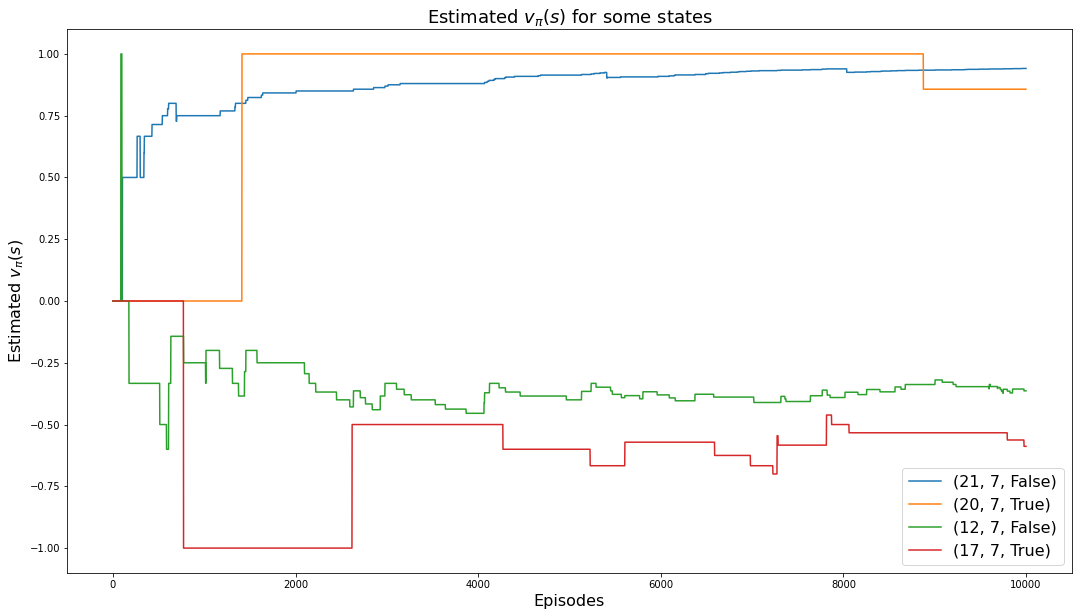

In [91]:
plt.rcParams["figure.figsize"] = (18,10)
for ms in monitored_states:
  plt.plot(monitored_state_values1[ms])
plt.title('Estimated $v_\pi(s)$ for some states', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $v_\pi(s)$', fontsize=16)
plt.legend(monitored_states, fontsize=16)
plt.show()

The following wireframe charts shows the estimate of the state-value function, $v_\pi(s)$, for the cases of a usable ace as well as not a usable ace:

In [92]:
AZIM = -120
ELEV = 40

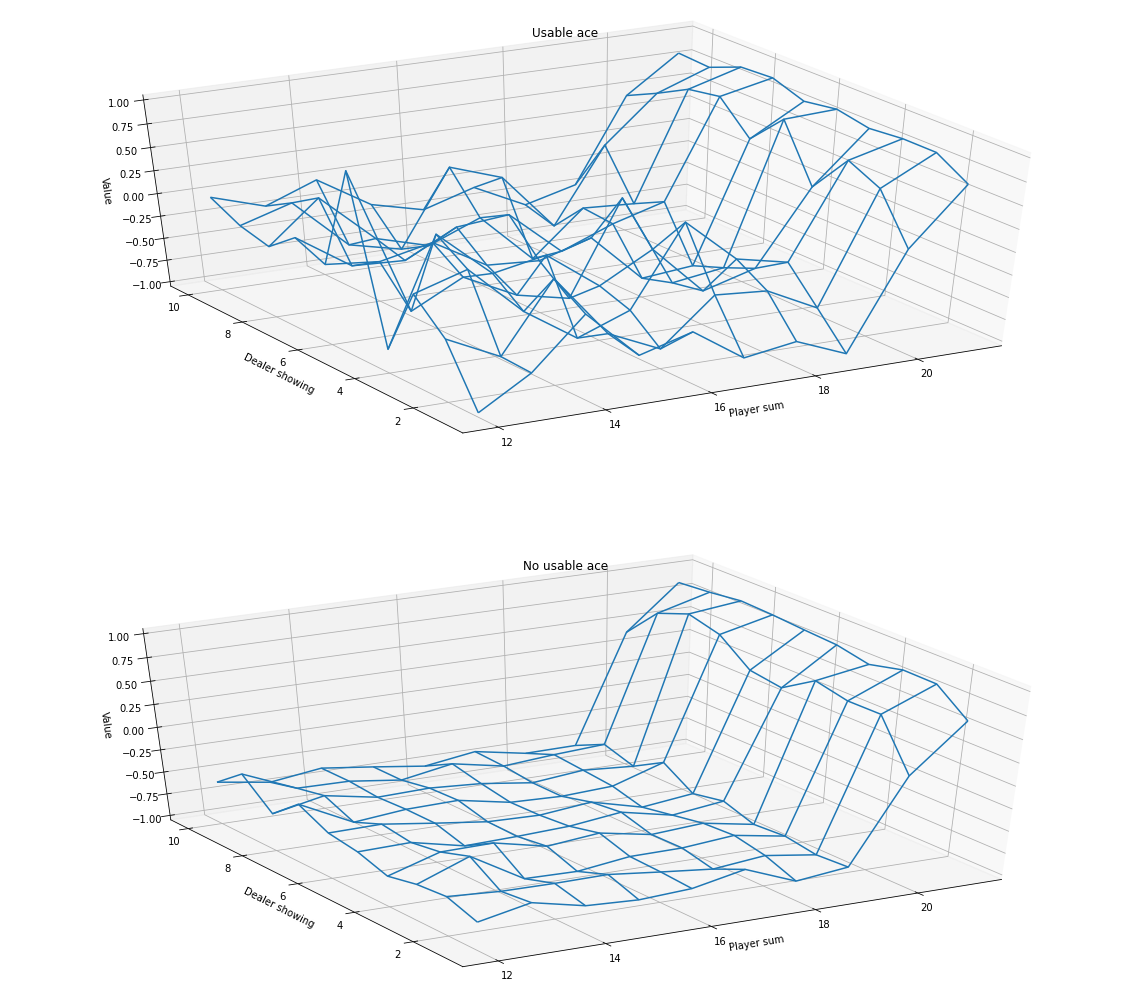

In [93]:
myplot.plot_state_value_function(V1, title="10,000 Steps", wireframe=True, azim=AZIM, elev=ELEV)

Here are the same charts but with coloration:

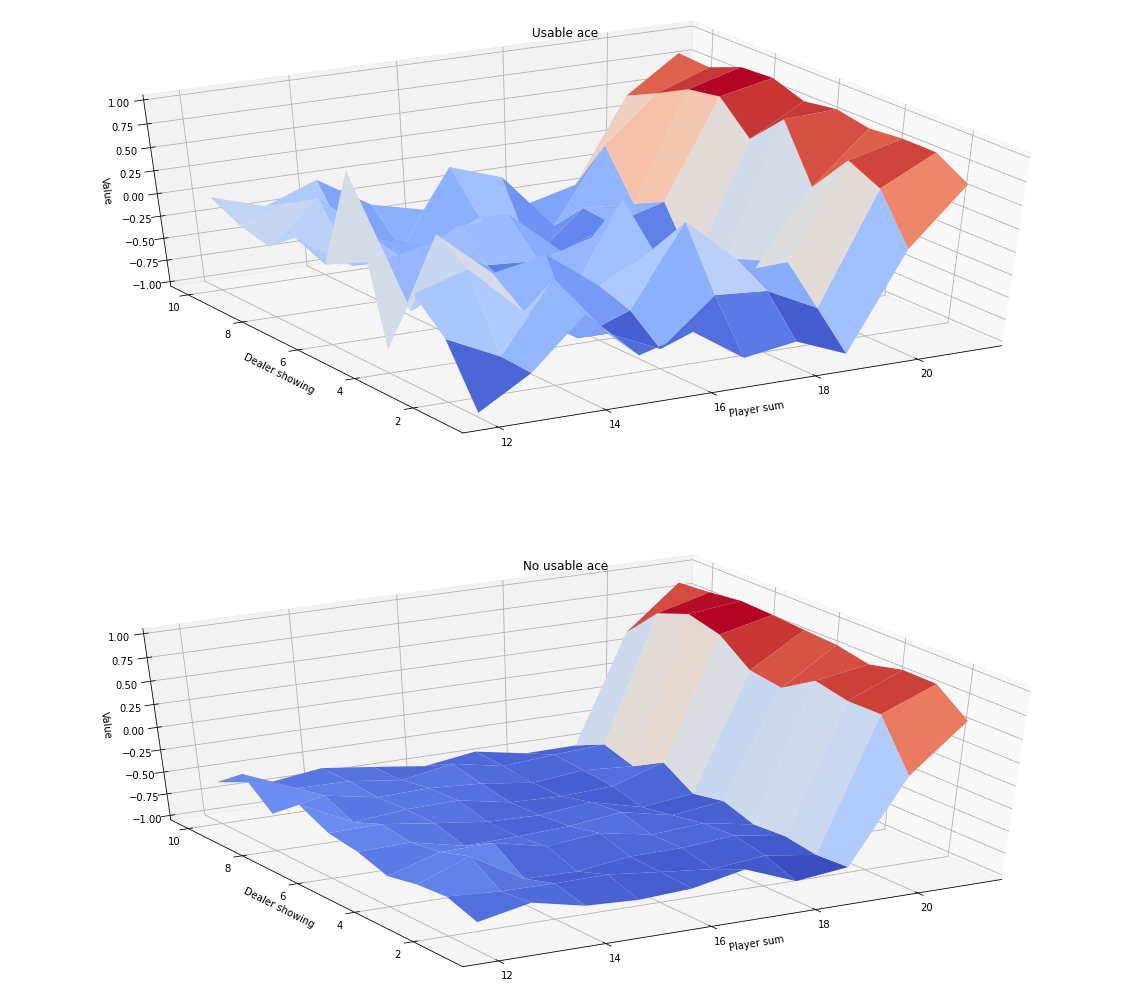

In [94]:
myplot.plot_state_value_function(V1, title="10,000 Steps", wireframe=False, azim=AZIM, elev=ELEV)

### 5.6 Run 2

Our final run uses 500,000 episodes and the accuracy of the state-value function is higher.

In [95]:
V2,monitored_state_values2 = mc_estimation(
    env, 
    n_episodes=500_000, 
    monitored_states=monitored_states,
    diag=False)

Episode 500000/500000

In [96]:
# last value in monitored_states should be value in V
ms = monitored_states[0]; print('ms:', ms)
monitored_state_values2[ms][-1], V2[ms]

ms: (21, 7, False)


(0.9212950776520137, 0.9212950776520137)

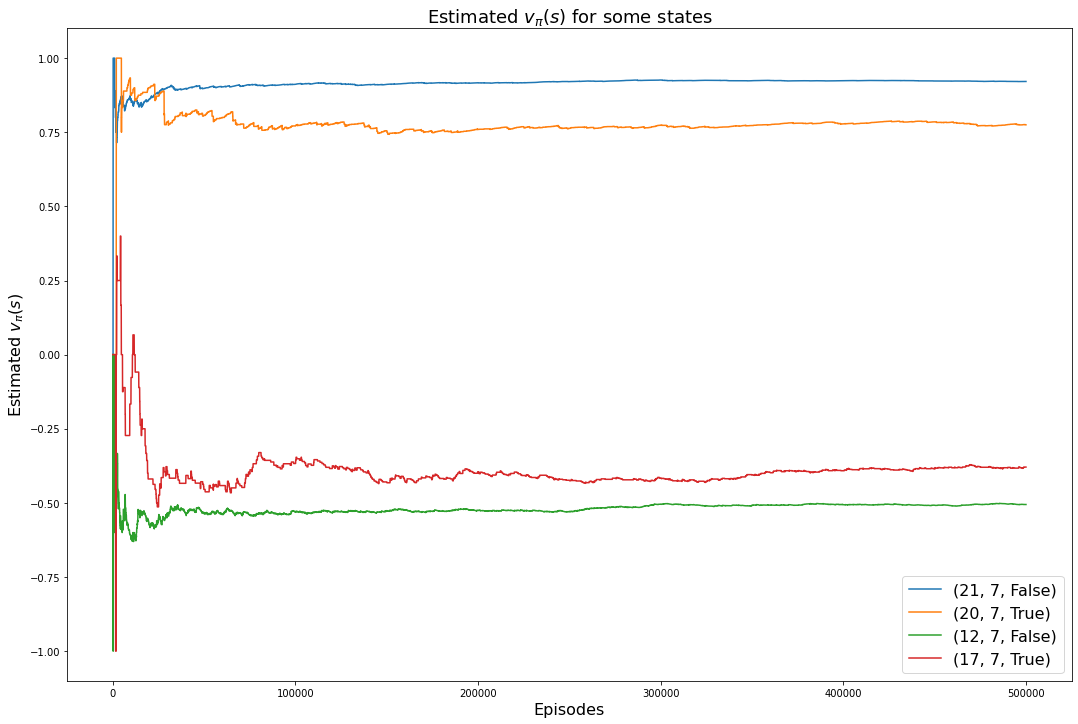

In [97]:
plt.rcParams["figure.figsize"] = (18,12)
for ms in monitored_states:
  plt.plot(monitored_state_values2[ms])
plt.title('Estimated $v_\pi(s)$ for some states', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $v_\pi(s)$', fontsize=16)
plt.legend(monitored_states, fontsize=16)
plt.show()

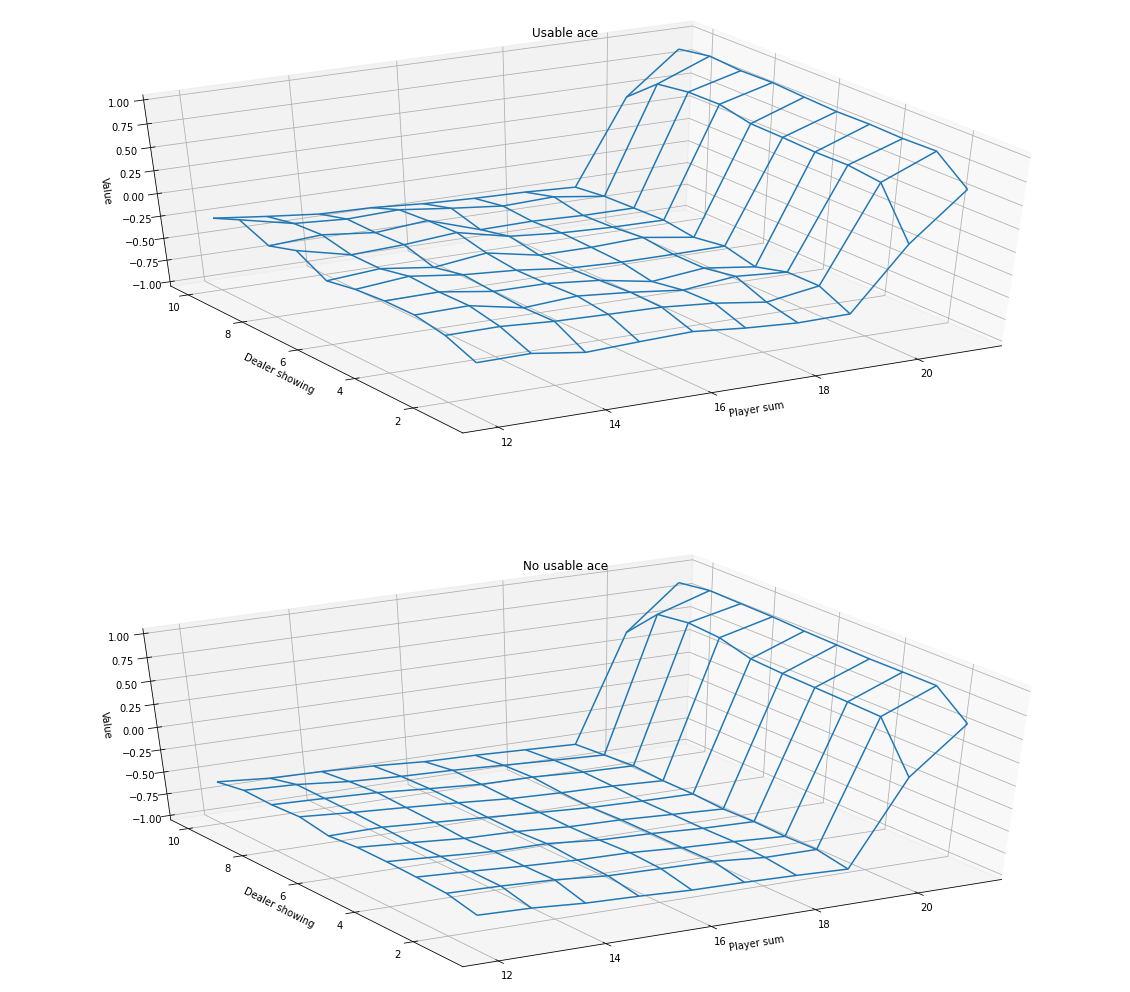

In [98]:
myplot.plot_state_value_function(V2, title="500,000 Steps", wireframe=True, azim=AZIM, elev=ELEV)

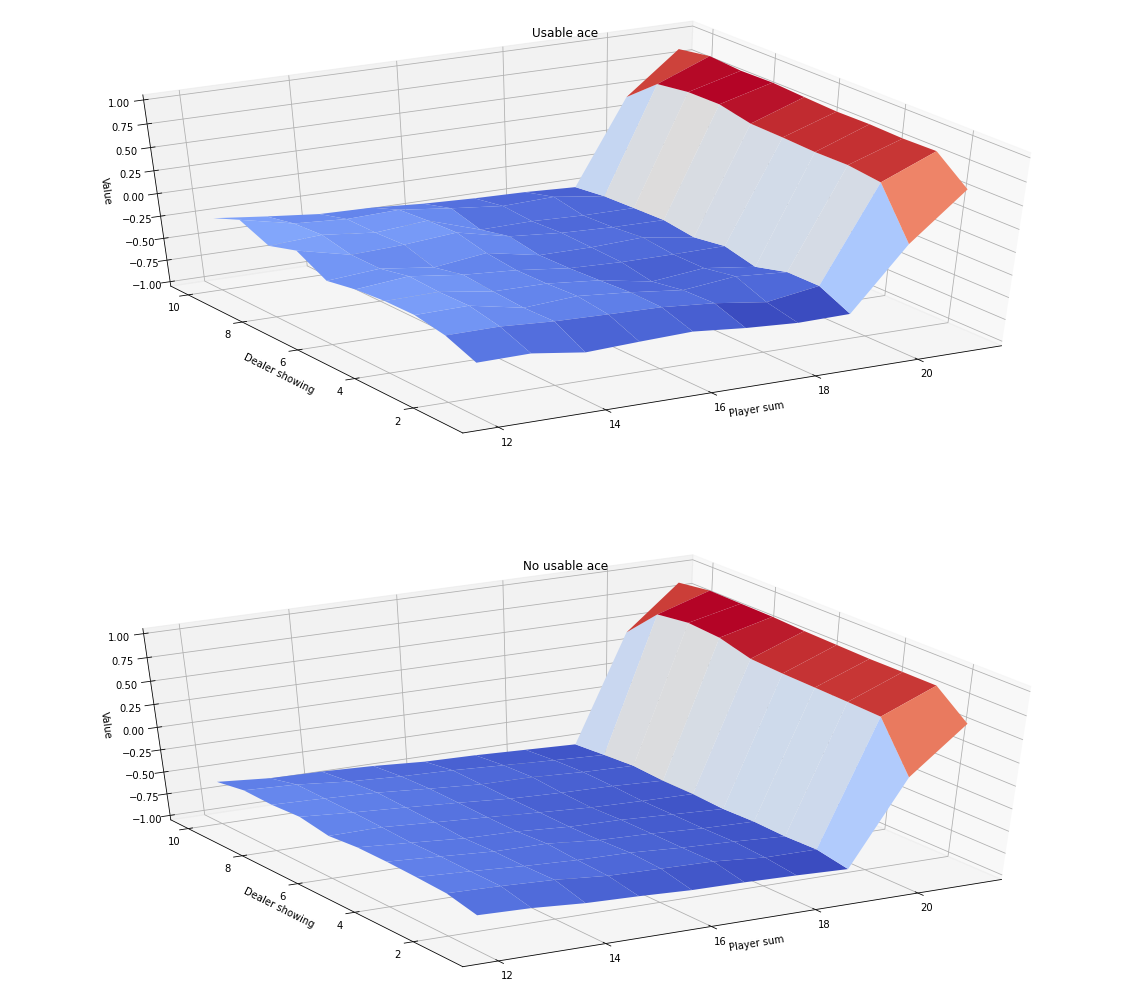

In [99]:
myplot.plot_state_value_function(V2, title="500,000 Steps", wireframe=False, azim=AZIM, elev=ELEV)